<div class="alert alert-primary">

Generate the network

1. Read the csv create the network and the links. New node is created if the movie doesn´t appear in the 250 movie

2. Clean the loops. Some movies have their own in related movies (second parts, etc...)

3. Add atributes but the synopsis with the txt.

</div>

In [61]:
import os
import re
import json
import requests
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import community.community_louvain as community_louvain

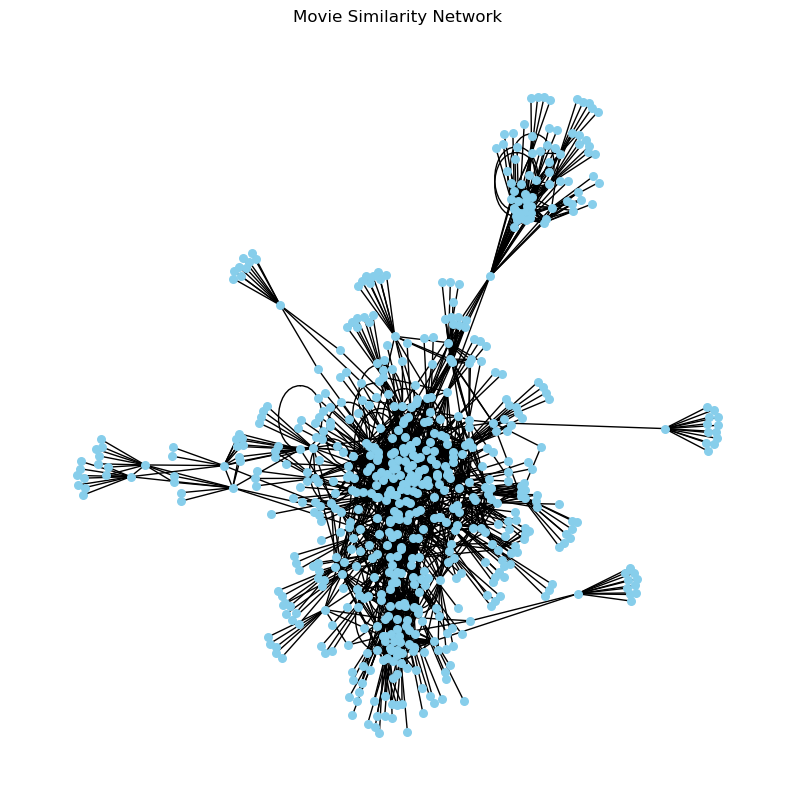

In [62]:


# Load the CSV file
file_path = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/top_movie_data_with_similar.csv'  # Replace with the actual file path


df = pd.read_csv(file_path)

# Create an empty undirected graph
G = nx.Graph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    G.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        G.add_edge(film, similar_film)

# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=False, node_size=30, node_color='skyblue', font_size=10)
plt.title("Movie Similarity Network")
plt.axis('off')
plt.show()


In [63]:
# print num of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 646
Number of edges: 2431


In [64]:
# Find all self-loops in the graph
self_loops = list(nx.selfloop_edges(G))

# Delete all self-loops
for edge in self_loops:
    G.remove_edge(edge[0], edge[1])


In [65]:
# print num of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 646
Number of edges: 2403


In [66]:
import os

# Folder containing the text files
metadata_folder = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/net_movies_info/net_movies_info'

# Function to parse a metadata text file and exclude the "Synopsis" field
def parse_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        key = None
        for line in lines:
            line = line.strip()
            if line.endswith(':'):
                key = line[:-1]  # Remove the colon
                if key == 'Synopsis':  # Skip "Synopsis"
                    key = None
                else:
                    metadata[key] = ''
            elif key:  # Append the value to the current key
                metadata[key] += (' ' + line if metadata[key] else line)
    return metadata

# Add metadata to the nodes in the graph, excluding 'Synopsis'
for node in G.nodes():
    # First, assume the filename matches the node title directly
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(G, {node: metadata})
    else:
        print(f"Metadata file not found for {node}")



In [67]:
# Convert genre attribute to a list
for node in G.nodes():
    if 'Genres' in G.nodes[node]:
        genre = G.nodes[node]['Genres']
        genre_list = [g.strip() for g in genre.split(',')]
        G.nodes[node]['Genres'] = genre_list

In [68]:
# Example: Check attributes of a specific node
sample_node = "12 Angry Men"  # Replace with a movie title in your dataset
if sample_node in G.nodes:
    # Print the metadata of the node in one line each
    for key, value in G.nodes[sample_node].items():
        print(f"{key}: {value}")

Title: 12 Angry Men 
Rating: 9.0 
Top 250 Rank: 5 
Duration: 96 
Release Date: 18 May 1959 (Denmark) 
Genres: ['Crime', 'Drama']
Director: Sidney Lumet 
Actors: Martin Balsam, John Fiedler, Lee J. Cobb, E.G. Marshall, Jack Klugman, Edward Binns, Jack Warden, Henry Fonda, Joseph Sweeney, Ed Begley 
Languages: English 
Description: The defense and the prosecution have rested, and the jury is filing into the jury room to decide if a young man is guilty or innocent of murdering his father. What begins as an open-and-shut case of murder soon becomes a detective story that presents a succession of clues creating doubt, and a mini-drama of each of the jurors' prejudices and preconceptions about the trial, the accused, AND each other. Based on the play, all of the action takes place on the stage of the jury room. 
Plot: ['The jury in a New York City murder trial is frustrated by a single member whose skeptical caution forces them to more carefully consider the evidence before jumping to a hast

<div class="alert alert-primary">

Calculate and print the IN-degree distribution and the OUT-degree distribution

1. Create the Directed Graph.
2. Analyze the In-Degree and the movies with more links in
3. Analyze the Out-Degree and the move with more out-degree


</div>

We need to read the graph as a Directed graph in order to calculate the IN-degree and the Out-degree.

- IN-DEGREE: the number of directed edges coming into that node. How many movies have that node as a related or similar movies.

- OUT-DEGREE: the number of directed edges going out from thaat node.

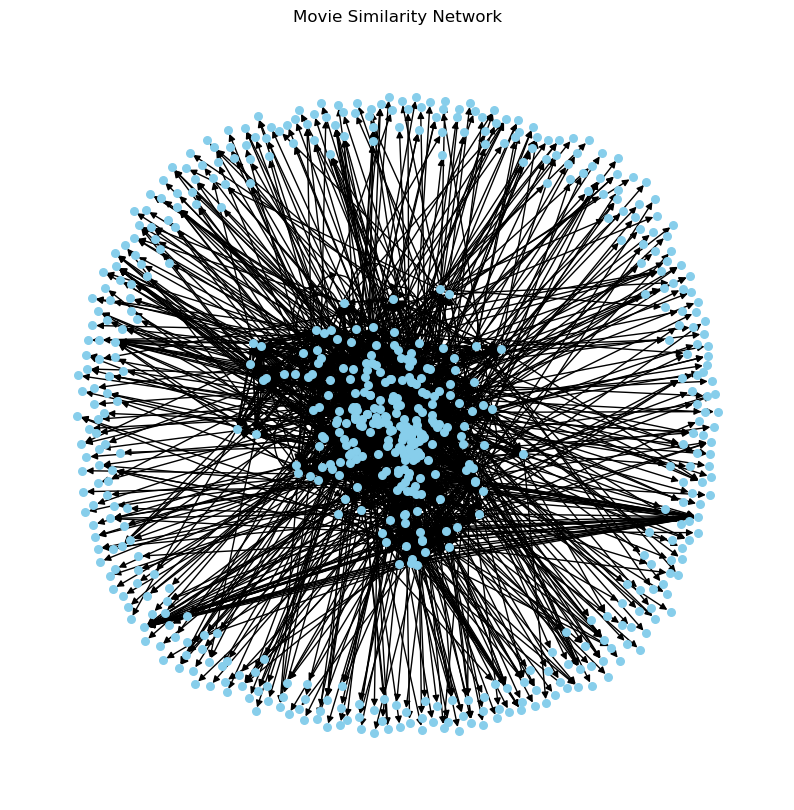

In [69]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'C:/Users/nerea/Documents/MasterDTU/SocialGraphs_fall24/Projects/socialGraphs_fall24/FinalProject/csv/top_movie_data_with_similar.csv'  # Replace with the actual file path


df = pd.read_csv(file_path)

# Create an empty undirected graph
D = nx.DiGraph()

# Add nodes and edges based on the similarity list
for index, row in df.iterrows():
    film = row['Name']
    similar_films = row['Similar Movies'].split(', ')  # Splitting the similar films into a list
    
    # Add the film as a node (it will be added automatically when creating edges)
    D.add_node(film)
    
    # Add edges between the film and its similar films
    for similar_film in similar_films:
        D.add_edge(film, similar_film)

# Find all self-loops in the graph
self_loops = list(nx.selfloop_edges(G))

# Delete all self-loops
for edge in self_loops:
    D.remove_edge(edge[0], edge[1])

# Add metadata to the nodes in the graph, excluding 'Synopsis'
# Add metadata to the nodes in the graph, excluding 'Synopsis'
for node in D.nodes():
    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    if os.path.exists(metadata_file):
        metadata = parse_metadata(metadata_file)
        nx.set_node_attributes(D, {node: metadata})

# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx(D, with_labels=False, node_size=30, node_color='skyblue', font_size=10)
plt.title("Movie Similarity Network")
plt.axis('off')
plt.show()


Text(0, 0.5, 'Frequency')

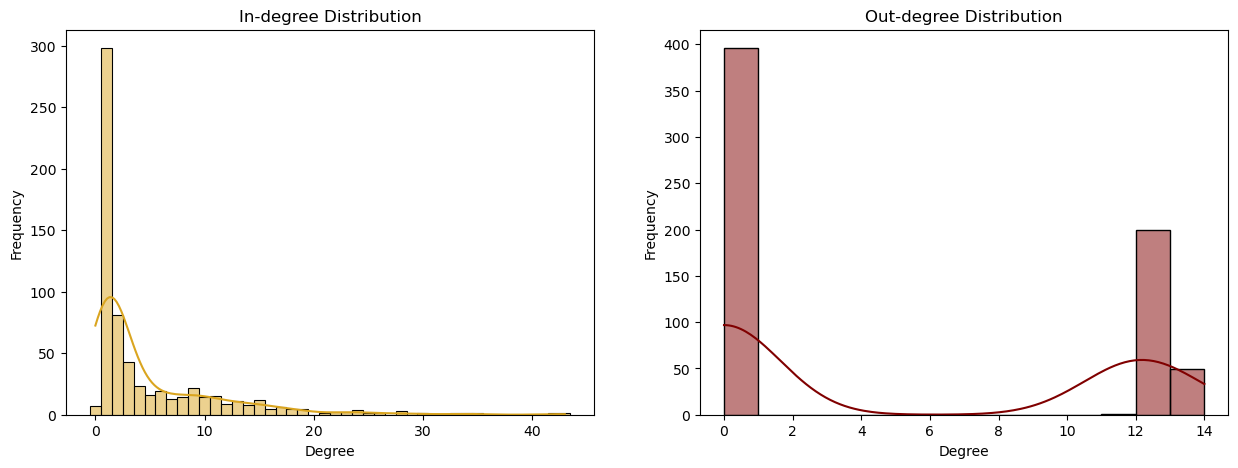

In [70]:
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in D.in_degree()]
out_degrees = [d for n, d in D.out_degree()]

# plot in and out degree distribution with seaborn
import seaborn as sns

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Plot histograms in separate plots same figure with seaborn
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)


# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")

**PROMBLEM**: Every time that a new movie appears in any related movie (and is not in the 250 list) we add a new node. Since we never look for the related movies of that specific node, they only have 1 node comming in and no node going out.

Thats why in the In-degree distribution we have a lot of nodes with only 1 or 2 edges pointing at them, suggesting that a big part of the 650 are in the network because they are mentioned only once.

The same happens in the out-degree, we have a lot of nodes with 0 edges existing from that node. Thats why we have 400 nodes that do not appear on the list, so they dont have related movies to point to.

Text(0, 0.5, 'Frequency')

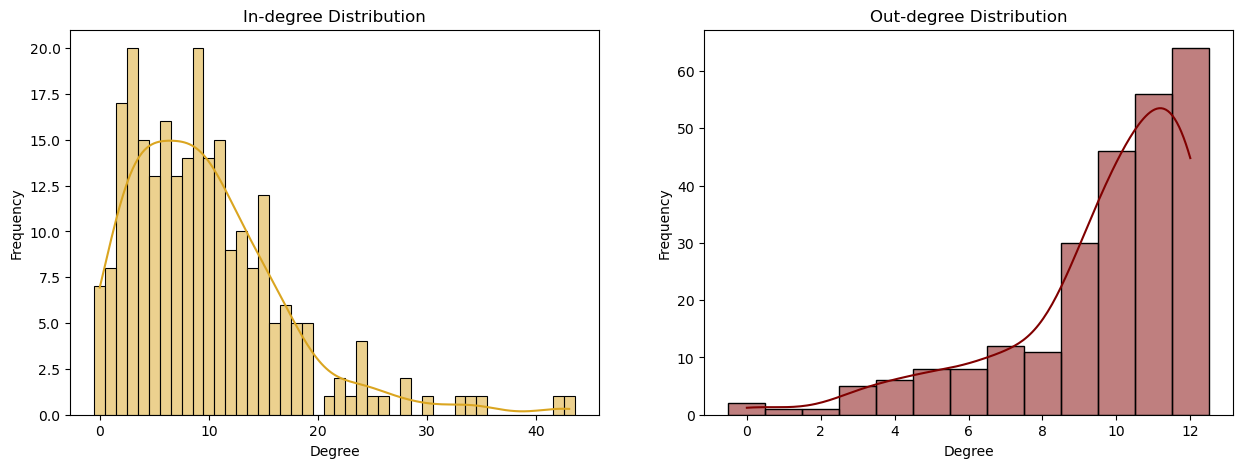

In [71]:
# make a copy of the graph
H = D.copy()

# Remove the nodes with out-degree = 0
nodes_to_remove = [node for node, out_degree in dict(H.out_degree()).items() if out_degree == 0]
H.remove_nodes_from(nodes_to_remove)

# plot the in-degree and out-degree distribution of the new graph with this change
# Get the in-degree and out-degree for each node
in_degrees = [d for n, d in H.in_degree()]
out_degrees = [d for n, d in H.out_degree()]

# Create a pandas Series from the degree lists
in_degree_series = pd.Series(in_degrees)
out_degree_series = pd.Series(out_degrees)

# Plot histograms in separate plots same figure with seaborn
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define bin width and range
binwidth = 1
binrange = (min(in_degrees) - 0.5, max(in_degrees) + 0.5)

# Plot the in-degree distribution as a histogram in the first subplot
sns.histplot(in_degree_series, color='goldenrod', kde=True, ax=ax1, binwidth=binwidth, binrange=binrange)
ax1.set_title("In-degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")

# Define bin range for out-degrees
binrange = (min(out_degrees) - 0.5, max(out_degrees) + 0.5)

# Plot the out-degree distribution as a histogram in the second subplot
sns.histplot(out_degree_series, color='maroon', kde=True, ax=ax2, binwidth=binwidth, binrange=binrange)
ax2.set_title("Out-degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency")



If we do the same analysis removing all the nodes that have 0 out-degree we can see that everything change.

The distribution is slightly right-skewed, meaning some movies are very popular and are listed as "related" by many others. The highest frequency lies in the mid-range of the in-degree values, suggesting that most movies are referenced as "related" by a moderate number of other films. Outliers on the high end (e.g., in-degrees of 30+) could indicate highly influential or broadly relatable movies.

High in-degree nodes (movies) act as hubs—they're referenced as related by many others. Examples might include culturally significant or widely influential films.


The out-degree distribution is sharply skewed toward smaller values, showing most movies link to only a few related films.
The peak at higher out-degrees suggests a maximum limit (e.g., 12), which could correspond to a predefined cap on how many "related movies" IMDb lists per film.

High out-degree nodes might represent movies that link to many others, perhaps because they belong to genres with multiple closely connected films (e.g., franchises).


In [72]:
# Top 10 nodes with highest in-degree with its genre and rating
in_degrees = dict(H.in_degree())
top_10_indegree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with highest in-degree:")
for node, indegree in top_10_indegree:
    print(f"{node} (In-degree: {indegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")


Top 10 nodes with highest in-degree:
Forrest Gump (In-degree: 43)
    Genres: Drama, Romance 
    Rating: 8.8 
Fight Club (In-degree: 42)
    Genres: Drama 
    Rating: 8.8 
Pulp Fiction (In-degree: 35)
    Genres: Crime, Drama 
    Rating: 8.9 
Inception (In-degree: 34)
    Genres: Action, Adventure, Sci-Fi, Thriller 
    Rating: 8.8 
Se7en (In-degree: 33)
    Genres: Crime, Drama, Mystery, Thriller 
    Rating: 8.6 
Shutter Island (In-degree: 30)
    Genres: Drama, Mystery, Thriller 
    Rating: 8.2 
Django Unchained (In-degree: 28)
    Genres: Comedy, Drama, Western 
    Rating: 8.5 
The Wolf of Wall Street (In-degree: 28)
    Genres: Biography, Comedy, Crime, Drama 
    Rating: 8.2 
Inglourious Basterds (In-degree: 26)
    Genres: Adventure, Drama, War 
    Rating: 8.4 
The Matrix (In-degree: 25)
    Genres: Action, Sci-Fi 
    Rating: 8.7 


Drama is the dominant genre among these movies. This suggests that dramas are central to the IMDb network of top-rated films, potentially because they appeal to a broad audience or resonate deeply with viewers.

Other popular genres include Crime, Thriller, and Biography, often representing films with complex, gripping narratives that leave a lasting cultural impact.

Many of these movies are associated with renowned directors (e.g., Christopher Nolan for Inception and The Dark Knight; Quentin Tarantino for Pulp Fiction) or feature iconic performances by celebrated actors. This reinforces their status as pivotal films in the IMDb network.

Movies with broad genre appeal (like Inception, blending action, sci-fi, and thriller elements) are more likely to connect to a wide variety of other films. This versatility likely explains their frequent appearance in the "related movies" lists.

In [73]:
# Top 10 nodes with highest out-degree with its genre and rating
out_degrees = dict(H.out_degree())
top_10_outdegree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with highest out-degree:")
for node, outdegree in top_10_outdegree:
    print(f"{node} (Out-degree: {outdegree})")
    print(f"    Genres: {H.nodes[node].get('Genres')}")
    print(f"    Rating: {H.nodes[node].get('Rating')}")

Top 10 nodes with highest out-degree:
The Shawshank Redemption (Out-degree: 12)
    Genres: Drama 
    Rating: 9.3 
The Dark Knight (Out-degree: 12)
    Genres: Action, Crime, Drama, Thriller 
    Rating: 9.0 
Forrest Gump (Out-degree: 12)
    Genres: Drama, Romance 
    Rating: 8.8 
Fight Club (Out-degree: 12)
    Genres: Drama 
    Rating: 8.8 
Pulp Fiction (Out-degree: 12)
    Genres: Crime, Drama 
    Rating: 8.9 
Inception (Out-degree: 12)
    Genres: Action, Adventure, Sci-Fi, Thriller 
    Rating: 8.8 
Schindler's List (Out-degree: 12)
    Genres: Biography, Drama, History 
    Rating: 9.0 
The Green Mile (Out-degree: 12)
    Genres: Crime, Drama, Fantasy, Mystery 
    Rating: 8.6 
Se7en (Out-degree: 12)
    Genres: Crime, Drama, Mystery, Thriller 
    Rating: 8.6 
Goodfellas (Out-degree: 12)
    Genres: Biography, Crime, Drama 
    Rating: 8.7 


It has no sense doing the out degree because the maximum related movies are 12

<div class="alert alert-primary">

Calculate the communities and some metrics for the communities

1. Create a partition based on genre
2. Create a partition based on director
3. Create partition using Louvian method
4. Calculate modularity for all of them
5. Calculate the confusion matrix


</div>

In [75]:
import networkx as nx

# Create a dictionary to hold the partition
genre_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Genres' attribute and split it into a list, if present
    genres = data.get("Genres", "")  # Default to an empty string if 'Genres' is missing

    # Get the first genre, or None if no genres are available
    first_genre = genres[0] if genres else None
    
    # Add node to the appropriate community in the partition
    if first_genre not in genre_partition:
        genre_partition[first_genre] = []
    genre_partition[first_genre].append(node)

print("We have a total of", len(genre_partition), "genres")
print()

# Print the partition for inspection
print("Partition based on first genre:")
for genre, nodes in genre_partition.items():
    print(f"{genre}: {len(nodes)} nodes")

# Convert the partition to a format usable by NetworkX for modularity calculation
# NetworkX requires a list of sets, where each set represents a community
# communities = [set(nodes) for nodes in partition.values()]




We have a total of 19 genres

Partition based on first genre:
Drama: 152 nodes
Action: 143 nodes
Crime: 68 nodes
Biography: 35 nodes
Short: 20 nodes
Adventure: 38 nodes
Comedy: 63 nodes
Music: 1 nodes
: 2 nodes
Animation: 72 nodes
Documentary: 26 nodes
Mystery: 5 nodes
Horror: 14 nodes
News: 1 nodes
Film-Noir: 2 nodes
Fantasy: 1 nodes
Family: 1 nodes
Thriller: 1 nodes
Sport: 1 nodes


In [76]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in genre_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the genre-based partition (formula book):", modularity_genre)

Modularity of the genre-based partition (formula book): 0.32332278506770135


In [77]:
# Do the partition with directors
# Create a dictionary to hold the partition
director_partition = {}

# Iterate over nodes in the graph and assign them to communities based on their first genre
for node, data in G.nodes(data=True):
    # Get the 'Directors' attribute and split it into a list, if present
    directors = data.get("Director", "")  # Default to an empty string if 'Genres' is missing
    directors_list = [g.strip() for g in directors.split(",")] if directors else []  # Split and strip spaces
    
    # Get the first genre, or None if no genres are available
    first_director = directors_list[0] if directors_list else None
    
    # Add node to the appropriate community in the partition
    if first_director not in director_partition:
        director_partition[first_director] = []
    director_partition[first_director].append(node)

print("We have a total of {} directors".format(len(director_partition)))
print()

# Print the partition for inspection
print("Partition based on first director:")
for director, nodes in director_partition.items():
    print(f"{director}: {len(nodes)} nodes")

We have a total of 309 directors

Partition based on first director:
Frank Darabont: 2 nodes
Christopher Nolan: 9 nodes
Francis Ford Coppola: 5 nodes
Robert Zemeckis: 4 nodes
David Fincher: 4 nodes
Quentin Tarantino: 8 nodes
Steven Spielberg: 10 nodes
Peter Jackson: 6 nodes
Sidney Lumet: 3 nodes
Martin Scorsese: 9 nodes
Jonathan Demme: 1 nodes
Lana Wachowski: 2 nodes
Todd Phillips: 2 nodes
None: 59 nodes
Cal Evans: 2 nodes
Roman Polanski: 3 nodes
Irvin Kershner: 1 nodes
Milos Forman: 2 nodes
Meg Pfeiffer: 1 nodes
Vidhu Vinod Chopra: 1 nodes
Rajkumar Hirani: 4 nodes
Nithilan Saminathan: 1 nodes
Nitesh Tiwari: 2 nodes
Kiran Rao: 1 nodes
Sandeep Reddy Vanga: 1 nodes
T.J. Gnanavel: 1 nodes
Nadine Labaki: 1 nodes
Nag Ashwin: 1 nodes
Nishikant Kamat: 1 nodes
Bahareh Ahmadi: 1 nodes
Liza Williams: 1 nodes
Pete Docter: 4 nodes
Roberto Benigni: 1 nodes
Richard Marquand: 1 nodes
George Lucas: 3 nodes
J.J. Abrams: 2 nodes
Rian Johnson: 1 nodes
Sudha Kongara: 1 nodes
Lokesh Kanagaraj: 2 nodes
Vetr

In [78]:
# Calculate L (total links) in the entire network
L = G.number_of_edges()

# Calculate modularity using the formula from chapter 9
modularity_genre = 0
for community in director_partition.values():
    subgraph = G.subgraph(community)
    
    # L_c: Count of edges within the community
    L_c = subgraph.number_of_edges()
    
    # k_c: Total degree of the nodes in this community
    k_c = sum(deg for node, deg in subgraph.degree())

    # Calculate modularity contribution for this community 
    # (L_C/L is the fraction of edges within the community, and k_c/(2L) is the expected fraction of edges in a random network)
    modularity_genre += ((L_c / L) - (k_c / (2 * L)) ** 2)

print("Modularity of the director-based partition (formula book):", modularity_genre)

Modularity of the director-based partition (formula book): 0.1321586330306703


In [79]:
# Compute the Louvain partition
partition_louvain = community_louvain.best_partition(G)

# Calculate modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(partition_louvain, G)
print("Modularity of Louvain partition:", modularity_louvain)

# Group nodes by their assigned community
community_groups = defaultdict(list)
for node, community in partition_louvain.items():
    community_groups[community].append(node)

# Print each community and the number of nodes in it
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {len(nodes)} nodes")

Modularity of Louvain partition: 0.6405036428836266
Community 1: 89 nodes
Community 2: 69 nodes
Community 7: 95 nodes
Community 5: 32 nodes
Community 6: 122 nodes
Community 9: 73 nodes
Community 10: 54 nodes
Community 4: 68 nodes
Community 3: 13 nodes
Community 8: 12 nodes
Community 11: 8 nodes
Community 0: 11 nodes


In [81]:
# Get the 10 most common genres
most_common_genres = sorted(genre_partition.keys(), key=lambda x: len(genre_partition[x]), reverse=True)[:10]

# Get 10 biggest communities
community_count = pd.Series(partition_louvain).value_counts()
biggest_communities = community_count.nlargest(10).index.tolist()

# Confusion matrix
confusion_matrix = np.zeros((len(most_common_genres), len(biggest_communities)))

# Fill the confusion matrix
for node in G.nodes():
    # Get the genres directly from the node attributes
    node_genres = G.nodes[node].get('Genres')
    node_community = partition_louvain[node]

    # Check if the community is one of the largest ones
    if node_community in biggest_communities:
        community_index = biggest_communities.index(node_community)

        # Count all genres for this node
        for genre in node_genres:
            if genre in most_common_genres:
                genre_index = most_common_genres.index(genre)
                confusion_matrix[genre_index, community_index] += 1

# Convert the confusion matrix to integers
confusion_matrix = confusion_matrix.astype(int)

# Display the confusion matrix with ints
confusion_df = pd.DataFrame(confusion_matrix, index=most_common_genres, columns=biggest_communities)
print("Confusion matrix:")
print(confusion_df)

Confusion matrix:
             6   7   1   9   2   4   10  5   3   8 
Drama        93  72  67  33   7  54  11  27   3  11
Action       14   6  29  11  43   7  43  15   2   2
Animation     4   3   0  38   0   0  27   0   1   0
Crime        42  14  26   2   0  14   2  12   1   5
Comedy       31  15   7  33   6  14   8   9   3   1
Adventure     3  14  18  45  38   5  35   4   2   0
Biography    17   9   9   6   1   1   1   3   1   0
Documentary   9   1   4   1   2   3   0   0   0   0
Short         8   6   4   0   3   1   1   0   2   0
Horror        2   4   3   2  19   2   0   1   5   5


<div style="border: 1px solid white; padding: 10px;">

* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix to dicusss the difference between the word-clouds between genres and communities.

</div>

In [82]:
import re
import math
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nerea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
synopsis = False

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

genre_text = {}

# Iterate over nodes in the graph and extract text data
for node, data in G.nodes(data=True):
    genres = data.get("Genres", "")

    metadata_file = os.path.join(metadata_folder, f"{node}.txt")
    
    # If the file doesn't exist, try replacing ":" and "?" with "_"
    if not os.path.exists(metadata_file):
        if node == "Car Crash: Who's Lying?":
            sanitized_node = "Car Crash_ Who's Lying_"
            metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
        else:
            for char in [':', '?']:
                sanitized_node = node.replace(char, '_')
                metadata_file = os.path.join(metadata_folder, f"{sanitized_node}.txt")
                if os.path.exists(metadata_file):
                    break
    
    # If the file exists, parse the metadata and add it to the node
    if os.path.exists(metadata_file):
        with open(metadata_file, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                if synopsis:
                    synopsis_text = line.strip()
                    synopsis_text = re.sub(r'[^\w\s]', '', synopsis_text) # Remove punctuation
                    synopsis_text = synopsis_text.lower() # Convert to lowercase
                    synopsis_text = re.sub(r"[^a-zA-Z\s]", " ", synopsis_text)  # Remove all non-alphabetic characters
                    synopsis_text = synopsis_text.lower()  # Convert text to lowercase
                    synopsis_text = re.sub(r"\b\w{1,2}\b", "", synopsis_text)  # Remove very short words (1-2 characters)
                    synopsis_text = re.sub(r"\s+", " ", synopsis_text).strip()  # Remove extra whitespace

                    # Remove stop words and lemmatize the words
                    words = word_tokenize(synopsis_text)
                    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
                    synopsis_text = " ".join(words)

                    # Agregate text for each genre
                    for genre in genres:
                        if genre not in genre_text:
                            genre_text[genre] = ""
                        genre_text[genre] += " " + synopsis_text
                    synopsis = False
                if line.strip().startswith("Synopsis:"):
                    synopsis = True

# Print genre_texts length
print("Genre's text length:")
for genre, text in genre_text.items():
    print(f"{genre}: {len(text)}")

Genre's text length:
Drama: 1474071
Action: 804892
Crime: 476873
Thriller: 649950
Romance: 268174
Adventure: 732185
Sci-Fi: 524770
Biography: 163066
History: 63437
Fantasy: 457107
Mystery: 371922
Musical: 53906
Short: 26
Western: 81088
War: 185070
Music: 23705
Comedy: 490933
: 2
Sport: 74522
Animation: 294478
Documentary: 6271
Family: 305926
Horror: 164710
Film-Noir: 47969
News: 1
